In [2]:
from __future__ import print_function, division

from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
from torchvision.datasets.folder import *
import PIL, gc

import matplotlib.pyplot as plt
import time
import os
import copy
from itertools import chain
import pretrainedmodels.utils as utils
import pretrainedmodels

from torchviz import make_dot, make_dot_from_trace

%matplotlib inline
plt.ion()   # interactive mode
BATCH = 1
N_layers = 2 # LSTM

In [3]:
# Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Special class
class MultiImageFolder(data.Dataset):
    """A generic data loader where the images are arranged in this way: ::
        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/xxz.png
        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/asd932_.png
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __init__(self, root, transform=None, target_transform=None,
                 loader=default_loader, len_seq=4):
        classes, class_to_idx = find_classes(root)
        imgs = make_dataset(root, class_to_idx, [".jpg",".jpeg",".png"])
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

        self.root = root
        self.imgs = imgs
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.len_seq =len_seq

    def __len__(self): 
        return len(self.imgs)//self.len_seq
        
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        img_l = []
        target_l = []
        for i in range(self.len_seq):
            path, target = self.imgs[self.len_seq*index+i]
            img = self.loader(path)
            if self.transform is not None:
                img = self.transform(img)
            if self.target_transform is not None:
                target = self.target_transform(target)
            if target_l and target != target_l[0]: break
            img_l += [img]
            target_l += [target]

        return img_l, target

# Datasets
data_dir = './LittlePlaNet/data/cities/'
image_datasets = {x: MultiImageFolder(os.path.join(data_dir, x),
                                           data_transforms[x], len_seq=8)
                   for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH,
                                           shuffle=True, num_workers=8, drop_last=True)
                   for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    hist = {"train":[], "val":[]}
        
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':            
                scheduler.step()
                model.train()  # Set model to training mode
                
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                                            # last batch classes
                    outputs = model(inputs)                                                
                    _, preds = torch.max(outputs, 1)
                    labels,
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * BATCH
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            hist[phase] += [[epoch_loss, epoch_acc]]
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, hist

In [15]:
model_ft = torch.load("models/resnet50_trained")

In [4]:
class Ensemble(nn.Module):
    def __init__(self, ms, out_dim):
        super(Ensemble, self).__init__()
        self.ms = ms
#         self.trf = trf
        self.out_dim = out_dim
        self.lin  = [nn.Linear(out_dim,out_dim).to(device) for i in range(len(ms))]
        for l in self.lin:
            l.weight = torch.nn.Parameter(torch.ones(out_dim,out_dim, device=device))
            l.bias = torch.nn.Parameter(torch.zeros(out_dim, device=device))
        self.k  = len(ms)
        
    def forward(self, Xs):
        #                     batch , out 
        res = torch.zeros(Xs[0].size(0), self.out_dim, requires_grad=True).to(device)
        for i in  range(len(Xs)):
            res +=  self.lin[i%self.k](self.ms[i%self.k](Xs[i].to(device)))
        res = nn.Softmax(dim=1)(res)
        return res

In [19]:
def avgmodel(m, inp):
    mn = torch.stack([m(inp[i].to(device)) for i in range(len(inp))]).squeeze().mean(0)
    if len(mn.shape) == 1: return mn.max(0)[1]
    return mn.max(1)[1]

In [21]:
# trf = nn.Sequential(*list(model_ft.children())[:-3])
# md  = nn.Sequential(*list(model_ft.children())[-3:])
ens = Ensemble([ model_ft for i in range(3)], 10)



In [22]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam( chain([list(ens.lin[i].parameters())[0] for i in range(3)],
                                 [list(ens.lin[i].parameters())[1] for i in range(3)]), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [23]:
ens, hist = train_model(ens,criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.2547 Acc: 0.3676
val Loss: 2.1996 Acc: 0.4167

Epoch 1/24
----------
train Loss: 2.1368 Acc: 0.5294
val Loss: 2.1735 Acc: 0.5417

Epoch 2/24
----------
train Loss: 2.0734 Acc: 0.5637
val Loss: 2.0904 Acc: 0.3333

Epoch 3/24
----------
train Loss: 2.0176 Acc: 0.6373
val Loss: 2.0061 Acc: 0.6667

Epoch 4/24
----------
train Loss: 1.9416 Acc: 0.7010
val Loss: 2.0049 Acc: 0.5417

Epoch 5/24
----------
train Loss: 1.9067 Acc: 0.7647
val Loss: 1.9575 Acc: 0.5417

Epoch 6/24
----------
train Loss: 1.9023 Acc: 0.7255
val Loss: 1.8947 Acc: 0.6667

Epoch 7/24
----------
train Loss: 1.8695 Acc: 0.7549
val Loss: 1.9473 Acc: 0.5417

Epoch 8/24
----------
train Loss: 1.8378 Acc: 0.8137
val Loss: 1.9824 Acc: 0.5000

Epoch 9/24
----------
train Loss: 1.8566 Acc: 0.7941
val Loss: 1.9733 Acc: 0.5833

Epoch 10/24
----------
train Loss: 1.8536 Acc: 0.7598
val Loss: 1.9781 Acc: 0.5417

Epoch 11/24
----------
train Loss: 1.8792 Acc: 0.7647
val Loss: 1.9216 Acc: 0.7083

Ep

In [21]:
newtestds = MultiImageFolder("data/cities/",data_transforms["test"],len_seq=5)
nt_dataloader = torch.utils.data.DataLoader(
    newtestds,batch_size=BATCH, shuffle=True, num_workers=4, drop_last=True)
class_names = newtestds.classes

In [6]:
ens = torch.load("models/ens_trained")
# ens.ms = [m.cpu() for m in ens.ms ]

In [26]:
#avg
preds = []
Y = []
for x,y in nt_dataloader:
    prs = avgmodel(model_ft,x)
#     prs = sm(x)[len(x)-1,:,:].max(1)[1]
    preds +=list(prs.cpu())
    Y += list(y.cpu())
scor = metrics.accuracy_score(Y, preds)
print( scor )
print(metrics.f1_score(Y,preds, average="weighted"))
plt.matshow(metrics.confusion_matrix(Y,preds).astype(np.double))

TypeError: iteration over a 0-d tensor

0.635
0.6377454501632739


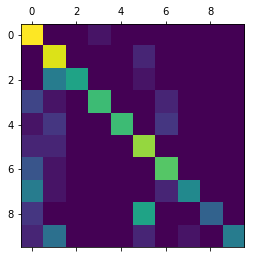

In [25]:
preds = []
Y = []
for x,y in nt_dataloader:
#     x = [xi.cpu() for xi in x]
    _, prs = ens(x).max(1)
    preds +=[prs.cpu()]
    Y +=[y.cpu()]
scor = metrics.accuracy_score(Y, preds)
print( scor )
print(metrics.f1_score(Y,preds, average="weighted"))
plt.matshow(metrics.confusion_matrix(Y,preds).astype(np.double))

In [28]:
torch.save(ens,"models/ens_trained")

/home/ashedko/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Ensemble. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [31]:
%matplotlib qt5
# hist= hist_new
train = np.asarray(hist["train"])
val = np.asarray(hist["val"])
plt.plot(range(25),train[:,0], label = "Train")
plt.plot(range(25),val[:,0], label = "Val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.yticks(np.arange(1.3,2.3, step=0.2))

Text(0,0.5,'Loss')

In [24]:
x,y = next(iter(dataloaders["val"]))
# x = x
# r = ens(x)
# x[1].shape
prs = avgmodel(model_ft,x)
prs

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fcdf0830400>>
Traceback (most recent call last):
  File "/home/ashedko/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/ashedko/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/ashedko/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/ashedko/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/home/ashedko/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/ashedko/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line

tensor(5, device='cuda:0')

Text(0.5,0,'Num examples')

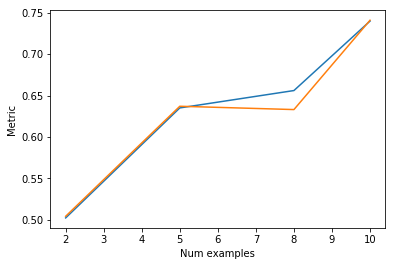

In [30]:
%matplotlib qt5
x=[2,5,8,10]
y1=[0.502,0.635,0.656,0.74]
y2=[0.504,0.637,0.633,0.741]

plt.plot(x,y1, label="ACC")
plt.plot(x,y2, label="F1")
plt.ylabel("Metric")
plt.xlabel("Num examples")